In [1]:
import numpy as np
import sklearn.manifold.forestsNaive as forestNaive
from sklearn.manifold.forests import ManifoldForest as forestProper
from sklearn.manifold import SpectralEmbedding
from time import time
from sklearn import datasets
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

#### AffinityForestSKlearnXX
Calling sklearn.ensemble.RandomForestRegressor with fit_transform(X,X) and criterion='mse' 

#### AffinityForestNaive
Our own first implementation that computes gaussian entropy. Assumes a fully populated binary tree.

#### AffinityForestNaiveRecursive
Own implementation using the same Splitter as above but due to rekursive tree building allows for not fully populated trees. (node with <= 1 samples is not split any more)

In [ ]:
data = np.random.rand(300, 5)
# np.seterr(all='raise')

In [ ]:
n_trees = 10
depth = 7
n_options = 50
n_features = 3


afSkl = forestNaive.AffinityForestSKlearnXX(n_trees, depth)
afRek = forestNaive.AffinityForestNaiveRecursive(n_trees, depth, n_options, n_features)
afNai = forestNaive.AffinityForestNaive(n_trees, depth, n_options, n_features)

t0 = time()
sklAffinity = afSkl.fit_transform(data)
t1 = time()
print("sklAffinityForest took {:.2f}s".format(t1-t0))

t1 = time()
rekAffinity = afRek.fit_transform(data)
t2 = time()
print("rekursive Affinity Forest took {:.2f}s".format(t2-t1))

t2 = time()
naiAffinity = afNai.fit_transform(data)
t3 = time()
print("naive affinity forest took {:.2f}s".format(t3-t2))

In [ ]:
print("naiveRekursive vs naiveFullBinary {:>.3f}".format(np.mean(np.abs(rekAffinity-naiAffinity))))
print("skl vs naiveFullBinary            {:>.3f}".format(np.mean(np.abs(sklAffinity-naiAffinity))))
print("skl vs naiveRekursive             {:>.3f}".format(np.mean(np.abs(sklAffinity-rekAffinity))))


In [2]:
def evaluate(embedder, datasetFunction=datasets.samples_generator.make_swiss_roll, n_points=2000):
    X, groundTruth = datasetFunction(n_points)
    t0 = time()
    predicted = embedder.fit_transform(X)
    t1 = time()
    
    Axes3D
    fig = plt.figure(figsize=(15, 8))
    plt.suptitle("{:.3f}seconds >> Left: origial, Right Embedding: {}".format((t1-t0), embedder))

    ax = fig.add_subplot(131, projection='3d')
    ax.set_title("original with ground Truth color")
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=groundTruth, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)

    ax = fig.add_subplot(132)
    ax.set_title("2d embedding with color as on the left")
    ax.scatter(predicted[:,1], predicted[:,0], c=groundTruth, cmap=plt.cm.Spectral)
#     ax.view_init(4, -72)

    ax = fig.add_subplot(133, projection='3d')
    ax.set_title("original with color proportional to \n most prominent 2d embeding dimension")
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=predicted[:,0], cmap=plt.cm.Spectral)
    ax.view_init(4, -72)

    plt.show() 
    
class PrecomputedEmbeder:
    def __init__(self, affinityClass, params, embedingClass):
        self.affinityClass = affinityClass
        self.embeder = embedingClass(n_components=2, affinity='precomputed')
        self.params = params
        
    def fit_transform(self, X):
        affinityComputer = self.affinityClass(**self.params)
        affinity = affinityComputer.fit_transform(X)
        
        return self.embeder.fit_transform(affinity)
    
    def __str__(self):
        return "PrecomputedEmbeder affinity= {}({}),\n embeding= {}".format(self.affinityClass.__name__, self.params, self.embeder.__class__)
        
        


In [3]:
def evaluateClustering(tree, nclusters, nelements, plotTrees=3):
    center = np.random.rand(nclusters, 2)*10
    
    clusterIDS = np.random.choice(nclusters, size=(nelements,))
    
    noise = np.random.normal(0, 0.33, size=(nelements, 2))
    
    result = center[clusterIDS] + noise
    
    fig = plt.figure(figsize=(20, 20))
    plt.suptitle("clustering with tree {}".format(tree))
    ax = fig.add_subplot(2,2,1)
    ax.set_title("ground truth")
    ax.scatter(result[:,0], result[:,1], c=clusterIDS)
    
    embedded = tree.fit_transform(result)
    print(embedded.shape)
    
    treeClustering = tree.apply(result)
    
#     print(treeClustering)
    
    for i in range(plotTrees):
        ax = fig.add_subplot(2,2,2+i)
        ax.set_title("clustering of tree {}".format(i))
        ax.scatter(result[:,0], result[:,1], c=treeClustering[:, i], cmap=plt.cm.Paired)
    
    plt.show()
    



(100, 100)


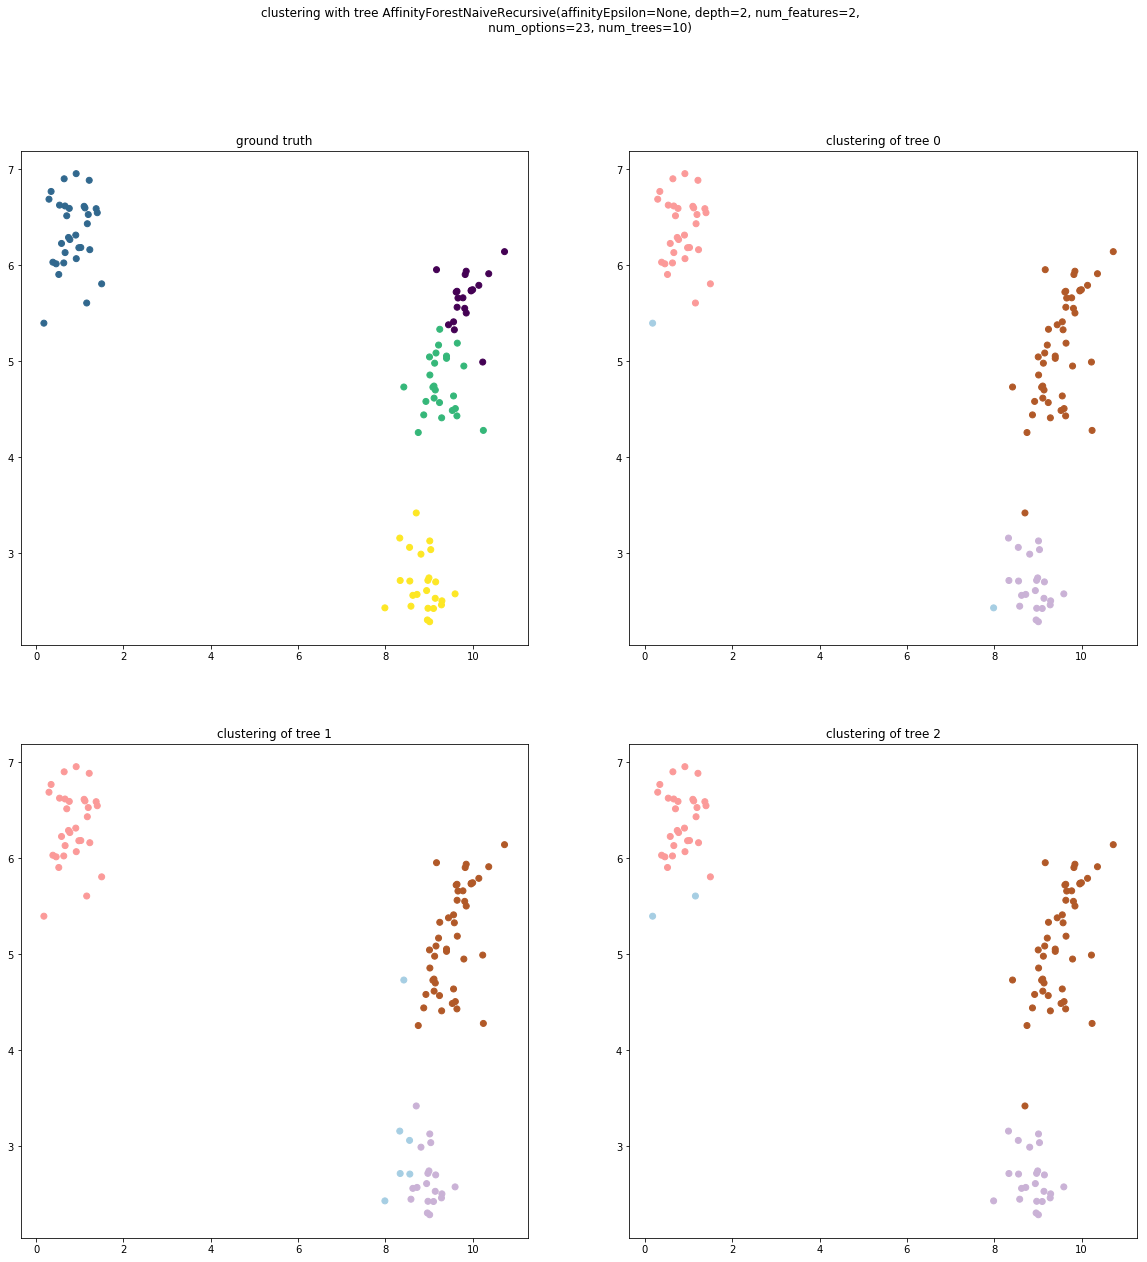

In [4]:
# evaluateClustering(forestNaive.AffinityForestSKlearnXX(10, 2), 4, 100)
evaluateClustering(forestNaive.AffinityForestNaiveRecursive(10, 2, num_options=23, num_features=2), 4, 100)
# evaluateClustering(forestNaive.AffinityForestNaive(10, 2, num_options=23, num_features=2), 4, 100)
# evaluateClustering(forestProper(n_estimators=10, max_depth=2), 4, 300)


In [10]:
n_trees = 50
depth = 10
n_options = 80
n_features = 2       
        
ForestEmbeddingSKlearn = PrecomputedEmbeder(forestNaive.AffinityForestSKlearnXX, dict(n_estimators=n_trees, max_depth=depth), SpectralEmbedding)
ForestEmbeddingRekursive = PrecomputedEmbeder(forestNaive.AffinityForestNaiveRecursive, dict(num_trees=n_trees, depth=depth, num_options=n_options, num_features=n_features, affinityEpsilon=0.2), SpectralEmbedding)
ForestEmbeddingNaive = PrecomputedEmbeder(forestNaive.AffinityForestNaive, dict(num_trees=n_trees, depth=depth, num_options=n_options, num_features=n_features), SpectralEmbedding)
ForestEmbedding = PrecomputedEmbeder(forestProper, dict(), SpectralEmbedding)

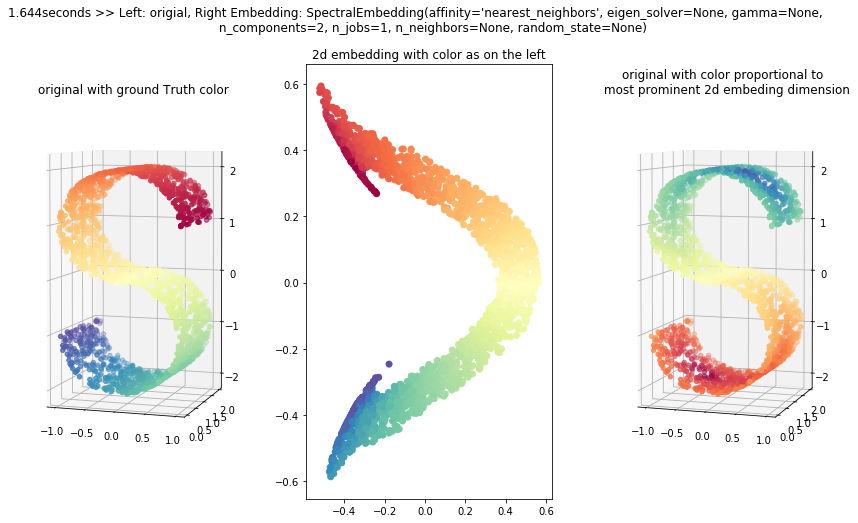

computing gaussian affinity
computing gaussian affinity
computing gaussian affinity
computing gaussian affinity
computing gaussian affinity
computing gaussian affinity


In [ ]:
dataset = datasets.samples_generator.make_s_curve

#evaluate raw
evaluate(SpectralEmbedding(n_components=2, affinity="nearest_neighbors"), dataset)

# evaluate(ForestEmbeddingSKlearn, dataset)

evaluate(ForestEmbeddingRekursive, dataset)

# evaluate(ForestEmbeddingNaive, dataset)

# evaluate(ForestEmbedding, dataset)

In [ ]:
dataset = datasets.samples_generator.make_swiss_roll

#evaluate raw
evaluate(SpectralEmbedding(n_components=2, affinity="nearest_neighbors"), dataset)

evaluate(ForestEmbeddingSKlearn, dataset)

evaluate(ForestEmbeddingRekursive, dataset)

# evaluate(ForestEmbeddingNaive, dataset)